In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os

In [2]:
root_path = "/Users/cdq/Desktop/opensource/FedPrompt/data/overall-performance/roberta-base-new-11.27"
output_fig_path = '/Users/cdq/Desktop/opensource/FedPrompt/figs/overall'

datasets = {"agnews": 1, "mnli": 0, "yahoo": 5, "yelp-full": 0}
all_client_num_in_total_list = {"agnews": 100, "yahoo": 1000, "yelp-full": 1000, "mnli": 1000}
alphas = {"agnews": 1, "yahoo": 0, "yelp-full": 0, "mnli": 0}
gammas = {"agnews": 0.001, "yahoo": 0.001, "yelp-full": 0.001, "mnli": 100}
full_set_acc= {"agnews": 0.93, "yahoo": 0.78, "yelp-full": 0.7, "mnli": 0.85}
seed = 6

# roberta-base
filenames_list = {
    "agnews": ["new_token_cpu_vote_stale_aug_0_conver_0_limit_0_fedclassifier_64_32_roberta-base_5_1_filter_-1.log", 
    "new_token_cpu_vote_stale_aug_100_conver_0_limit_0_fedpet_64_32_roberta-base_5_1_filter_-1.log","bitfit_fedpet_roberta-base_train_examples_64_f_100_n_1_k_5_filter_-1.log",
    "new_token_cpu_vote_stale_aug_5_conver_0_limit_0_fedpet_64_32_roberta-base_5_1_filter_0.1.log"],
    "mnli": ["new_token_cpu_vote_stale_aug_0_conver_0_limit_0_fedclassifier_64_32_roberta-base_5_1_filter_-1.log", 
    "new_token_cpu_vote_stale_aug_100_conver_0_limit_0_fedpet_64_32_roberta-base_5_1_filter_-1.log","bitfit_fedpet_roberta-base_train_examples_64_f_100_n_1_k_5_filter_-1.log",
    "new_token_cpu_vote_stale_aug_5_conver_0_limit_0_fedpet_64_32_roberta-base_5_1_filter_0.2.log"],
    "yahoo": ["new_token_cpu_vote_stale_aug_0_conver_0_limit_0_fedclassifier_64_32_roberta-base_5_1_filter_-1.log", 
    "new_token_cpu_vote_stale_aug_100_conver_0_limit_0_fedpet_64_32_roberta-base_5_1_filter_-1.log","bitfit_fedpet_roberta-base_train_examples_64_f_100_n_1_k_5_filter_-1.log",
    "new_token_cpu_vote_stale_aug_5_conver_0_limit_0_fedpet_64_32_roberta-base_5_1_filter_0.1.log"],
    "yelp-full": ["new_token_cpu_vote_stale_aug_0_conver_0_limit_0_fedclassifier_64_32_roberta-base_5_1_filter_-1.log", 
    "new_token_cpu_vote_stale_aug_100_conver_0_limit_0_fedpet_64_32_roberta-base_5_1_filter_-1.log","bitfit_fedpet_roberta-base_train_examples_64_f_100_n_1_k_5_filter_-1.log",
    "new_token_cpu_vote_stale_aug_5_conver_0_limit_0_fedpet_64_32_roberta-base_5_1_filter_0.5.log"],
}

# per batch latency, bs = 4, msl = 256. robert-base ·= robert-large / 2
train_latency_list = {"tx2+bitfit": 1 / 2, "tx2+full": 2 / 2}
infer_latency_list = {"tx2+bitfit": 0.5 / 2, "tx2+full": 1 / 2}
communication_latency_list = {"bitfit": 400 * 2 / 1000 / 1, "full": 400 * 2 / 1}

labels = ["FedCLS", "Ours", "Ours+", "Ours++"]

In [3]:
# plot hyper-para.
colors=['r','g', 'b','y','c','m','k'] * 100
full_set_acc= {"agnews": 0.93, "yahoo": 0.78, "yelp-full": 0.7, "mnli": 0.85}

/Users/cdq/Desktop/opensource/FedPrompt/data/overall-performance/roberta-base-new-11.27/agnews/all_100/seed_6/pattern_1/alpha_1_beta_0_gamma_0.001/new_token_cpu_vote_stale_aug_0_conver_0_limit_0_fedclassifier_64_32_roberta-base_5_1_filter_-1.log
max accuracy is 0.3540789473684211, round is 220
            0
0        0.25
1        0.25
2        0.25
3        0.25
4        0.25
..        ...
706  0.336447
707  0.336447
708  0.336447
709  0.336447
710  0.336447

[711 rows x 1 columns]
range(0, 50)
[[0.2688172 ]
 [0.2688172 ]
 [0.2688172 ]
 [0.2688172 ]
 [0.2688172 ]
 [0.2688172 ]
 [0.26895869]
 [0.26952462]
 [0.27532541]
 [0.27334465]
 [0.28480475]
 [0.30744199]
 [0.31607244]
 [0.32583475]
 [0.35894171]
 [0.35894171]
 [0.36375212]
 [0.32753254]
 [0.35696095]
 [0.34083192]
 [0.32739106]
 [0.35130164]
 [0.35540464]
 [0.35342388]
 [0.35526316]
 [0.35597057]
 [0.35172609]
 [0.35526316]
 [0.35625354]
 [0.35710243]
 [0.35483871]
 [0.35681947]
 [0.35681947]
 [0.3565365 ]
 [0.35766836]
 [0.358375

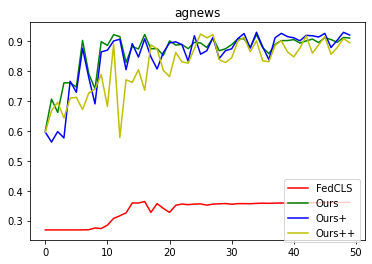

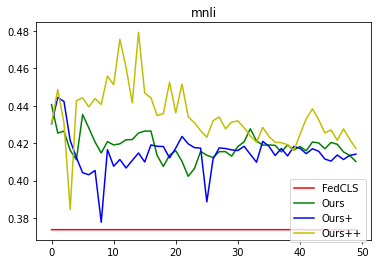

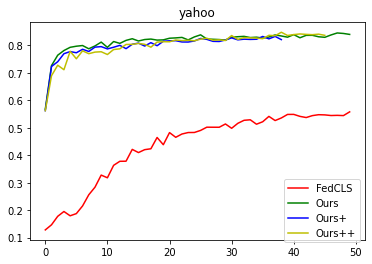

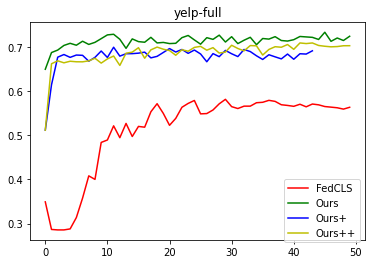

In [4]:
# round to accuracy
# i=0
acc_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}
round_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}
for dataset in filenames_list:

    log_root_path = os.path.join(root_path,f"{dataset}/all_{all_client_num_in_total_list[dataset]}/seed_{seed}/pattern_{datasets[dataset]}/alpha_{alphas[dataset]}_beta_0_gamma_{gammas[dataset]}")

    filenames = filenames_list[dataset]

    fig = plt.figure()
    plt.title(dataset)
    for filename in filenames:
        log_path = os.path.join(log_root_path,filename)

        iter = 1000
        phrase = 'aggregated model performance is'
        with open(log_path) as f:
            f = f.readlines()
        df = pd.DataFrame(data=None, index = range(iter), columns = range(1))
        for line in f:
            if phrase in line:
                gen = int(re.findall(r'Gen (.+?) ',line)[0])
                
                acc = float(re.findall(r': ?(\d+\.\d+)',line)[0])
                df[0][gen]=acc

        df = df.dropna(axis=0, how='any') 

        this_max_acc = np.max(df[0])
        idx = [df[0].to_list().index(x) for x in df[0] if x == this_max_acc][0]
        print(log_path)
        print(f"max accuracy is {this_max_acc}, round is {idx}")
        print(df)
        acc_list[dataset].append(this_max_acc)
        round_list[dataset].append(idx)
        
        iter = min(len(df.index),50)
        y_mean = []
        for j in range(iter):
            y = np.array(df.iloc[j])

            y_mean.append(pd.DataFrame(y).dropna().mean())
            # plt.scatter(j, y)
        print(range(iter))
        print(np.array(y_mean)/full_set_acc[dataset])
        print(colors[filenames.index(filename)])

        plt.plot(range(iter),np.array(y_mean)/full_set_acc[dataset],label=labels[filenames.index(filename)],color=colors[filenames.index(filename)])
    fig.legend(loc="lower right",bbox_to_anchor=(0.9,0.1),bbox_transform=fig.transFigure)
    fig.savefig(os.path.join(output_fig_path, f"{dataset}-roberta-base-new-11.27-round2accuracy.pdf"))

In [5]:
acc_list

{'agnews': [0.3540789473684211, 0.866578947368421, 0.8722368421052632, 0.86],
 'mnli': [0.4195419363538296,
  0.37452878247580235,
  0.3777890983188996,
  0.4074375955170657],
 'yahoo': [0.4475166666666667, 0.66035, 0.64925, 0.66105],
 'yelp-full': [0.40670000000000006, 0.51288, 0.48916, 0.49626]}

4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0
4000.0

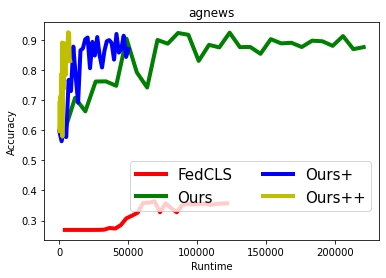

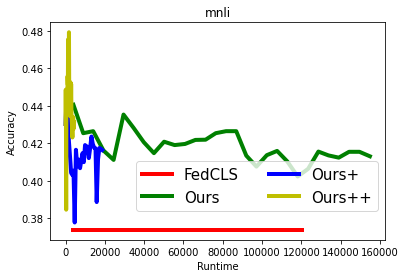

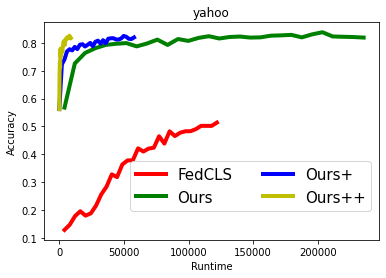

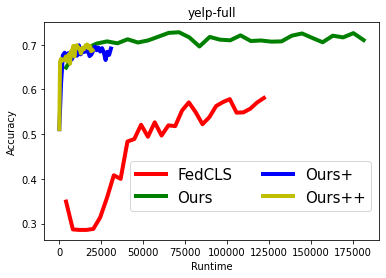

In [6]:
# time to accuracy  
t = 0   
acc_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}
runtime_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}     
for dataset in filenames_list:

    log_root_path = os.path.join(root_path,f"{dataset}/all_{all_client_num_in_total_list[dataset]}/seed_{seed}/pattern_{datasets[dataset]}/alpha_{alphas[dataset]}_beta_0_gamma_{gammas[dataset]}")

    filenames = filenames_list[dataset]

    fig = plt.figure()
    plt.title(dataset)
    plt.xlabel("Runtime")
    plt.ylabel("Accuracy")
    for filename in filenames:
        log_path = os.path.join(log_root_path,filename)
        if not os.path.exists(log_path):
            print(f"{log_path} not exists")
            continue

        iter = 1000
        phrase = 'train data'
        with open(log_path) as f:
            f = f.readlines()
        df = pd.DataFrame(data=None, index = range(iter), columns = range(1))
        runtime = []
        train_runtime = []
        infer_runtime = []
        time_stamp = 0
        train_time_stamp = 0
        infer_time_stamp = 0

        for line in f:
            if phrase in line:
                line_idx = f.index(line)
                
                train_info = f[line_idx]
                infer_info = f[line_idx + 1]
                
                if filenames.index(filename) <= 1:
                    # TX2: train, 1s/sample, infer, 0.5s/sample, no comm. because bit fit is parameter efficient.
                    train_time = sum(list(map(int, re.findall(r'\d+', train_info.split("Gen")[1])))[1:]) * train_latency_list["tx2+full"]
                    infer_time = sum(list(map(int, re.findall(r'\d+', infer_info.split("Gen")[1])))[1:]) * infer_latency_list["tx2+full"]
                else:
                    # TX2: train, 1s/sample, infer, 0.5s/sample, no comm. because bit fit is parameter efficient.
                    train_time = sum(list(map(int, re.findall(r'\d+', train_info.split("Gen")[1])))[1:]) * train_latency_list["tx2+bitfit"]
                    infer_time = sum(list(map(int, re.findall(r'\d+', infer_info.split("Gen")[1])))[1:]) * infer_latency_list["tx2+bitfit"]
                
                if filenames.index(filename) <= 1:
                    comm_time = communication_latency_list["full"] * 5
                else:
                    comm_time = communication_latency_list["bitfit"] * 5
                print(comm_time)
                time_stamp = time_stamp + train_time + infer_time + comm_time # elasped time of all clients / energy consumption
                train_time_stamp = train_time + train_time_stamp
                infer_time_stamp = infer_time + infer_time_stamp

                runtime.append(time_stamp)
                train_runtime.append(train_time_stamp)
                infer_runtime.append(infer_time_stamp)
            if 'aggregated model performance is' in line: 
                gen = int(re.findall(r'Gen (.+?) ',line)[0])
                
                acc = float(re.findall(r': ?(\d+\.\d+)',line)[0])
                df[0][gen]=acc

        df = df.dropna(axis=0, how='any') # any 只要有 nan 就会删掉。 all　是必须全是nan才删除; 0: 行；1：列
        if df.empty:
            print(f"Bug: {log_path}")

        this_max_acc = np.max(df[0])
        # idx = [df[0].to_list().index(x) for x in df[0] if x == this_max_acc][0]
        print(log_path)
        # print(f"max accuracy is {this_max_acc}, runtime is {runtime[idx]}")
        acc_list[dataset].append(this_max_acc)
        # runtime_list[dataset].append(runtime[idx])
        # df.to_csv("/Users/cdq/Desktop/opensource/FedPrompt/data/softlabel/agnews_aug_fedpet_128_32_roberta-large.csv")
        iter = min(len(df.index),30)
        y_mean = []
        for j in range(iter):
            y = np.array(df.iloc[j])

            y_mean.append(pd.DataFrame(y).dropna().mean())
            # plt.scatter(j, y)
        print(len(runtime),len(list(map(float, y_mean))))
        plt.plot(runtime[:len(y_mean)],np.array(y_mean)/full_set_acc[dataset],label=labels[filenames.index(filename)],color=colors[filenames.index(filename)],linewidth=4)
    fig.legend(loc="lower right",bbox_to_anchor=(0.9,0.2),bbox_transform=fig.transFigure,ncol=2,fontsize=15)
    fig.savefig(os.path.join(output_fig_path, f"{dataset}-roberta-base-new-11.27-time2accuracy.pdf"))